<a href="https://colab.research.google.com/github/SaadNazir1/Bank-Project/blob/main/GROUP4_DAHCC_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project**: Data Analytics in Health Care & Connected Care
#              **Mortality Prediction Model for ICU patients with Heart Failure**
#              (Academic Year 2023/2024)



```
Saad Nazir: 0608573

Ghulam Mustafa Imran: 0611022

Momina Jamil: 0612857


Syed Fahim Haider Kazmi: 0610449

```




# Credentializing Colab

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# Loading the data from Big Query

 Data is loaded from bigQuery and ready for making valueable dataset for analysis and model training.

**Extracting the codes of heart diseases from the mimic dataset.**

In [ ]:
%%bigquery  --project fourth-fact-417009
select count(*) as Type_of_HeartFailures from `physionet-data.mimiciii_clinical.d_icd_diagnoses`
        where LONG_TITLE LIKE "%heart failure%" OR LONG_TITLE LIKE "Heart failure"

Query is running:   0%|          |

Downloading:   0%|          |

,Type_of_HeartFailures
0,33


**1. Getting the useful information from patients,diagnoses_icd,d_icd_diagnoses, chart events, d_items,icu_stay and admissions tables**

In [ ]:
%%bigquery  dataset_p1 --project fourth-fact-417009

SELECT  d.SUBJECT_ID as Patient_ID, DATETIME_DIFF(a.ADMITTIME, p.DOB, YEAR) as age, p.GENDER, a.ETHNICITY, item.LABEL as Chart_label, ch.VALUENUM as Chart_Value,
    a.DIAGNOSIS, dc.LONG_TITLE as Type_of_Heart_Failure,icu.LOS,p.expire_flag,
FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses` dc
INNER JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` d ON d.ICD9_CODE = dc.ICD9_CODE
INNER JOIN `physionet-data.mimiciii_clinical.admissions` a
  ON a.SUBJECT_ID = d.SUBJECT_ID and a.HADM_ID = d.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.patients` p
   ON p.SUBJECT_ID = d.SUBJECT_ID
INNER JOIN `physionet-data.mimiciii_clinical.icustays` icu
 ON icu.SUBJECT_ID = d.SUBJECT_ID and a.HADM_ID = icu.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.chartevents` ch
   ON d.SUBJECT_ID = p.SUBJECT_ID and ch.HADM_ID = a.HADM_ID and ch.ICUSTAY_ID = icu.ICUSTAY_ID
INNER JOIN `physionet-data.mimiciii_clinical.d_items` item
   ON item.ITEMID = ch.ITEMID

WHERE (dc.LONG_TITLE LIKE "%heart failure%" OR dc.LONG_TITLE LIKE "%Heart failure%")
    and  DATETIME_DIFF(a.ADMITTIME, p.DOB, YEAR) BETWEEN 0 AND 100 and ch.VALUENUM is not null
ORDER BY d.SUBJECT_ID, d.HADM_ID LIMIT 1000000

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
dataset_p1

,Patient_ID,age,GENDER,ETHNICITY,Chart_label,Chart_Value,DIAGNOSIS,Type_of_Heart_Failure,LOS,expire_flag
0,3,76,M,WHITE,Arterial BP [Systolic],100.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
1,3,76,M,WHITE,Arterial PaCO2,29.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
2,3,76,M,WHITE,Arterial Base Excess,-9.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
3,3,76,M,WHITE,Arterial BP [Systolic],88.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
4,3,76,M,WHITE,calprevflg,1.0,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
...,...,...,...,...,...,...,...,...,...,...
999995,766,86,F,WHITE,ABP Alarm [High],160.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),1.5143,1
999996,766,86,F,WHITE,Respiratory Rate,15.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999997,766,86,F,WHITE,SpO2,97.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999998,766,86,F,WHITE,CVP,14.0,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1


In [ ]:
%%bigquery  dataset_p2 --project fourth-fact-417009
SELECT d.SUBJECT_ID as Patient_ID, ilab.LABEL as Lab_label, lab.VALUENUM as LAB_value,
FROM `physionet-data.mimiciii_clinical.d_icd_diagnoses` dc
INNER JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` d
      ON d.ICD9_CODE = dc.ICD9_CODE
INNER JOIN `physionet-data.mimiciii_clinical.labevents` lab
      ON lab.SUBJECT_ID = d.SUBJECT_ID and lab.HADM_ID = d.HADM_ID
INNER JOIN `physionet-data.mimiciii_clinical.d_labitems` ilab
      ON ilab.ITEMID = lab.ITEMID

WHERE (dc.LONG_TITLE LIKE "%heart failure%" OR dc.LONG_TITLE LIKE "%Heart failure%")
      and d.SUBJECT_ID <= 766
      ORDER BY d.SUBJECT_ID, d.HADM_ID  LIMIT 1000000


Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
dataset_p2

,Patient_ID,Lab_label,LAB_value
0,3,Hemoglobin,8.8
1,3,Anisocytosis,NaN
2,3,Nitrite,NaN
3,3,Ventilation Rate,NaN
4,3,Oxygen Saturation,68.0
...,...,...,...
173189,766,Potassium,4.3
173190,766,Intubated,NaN
173191,766,"Hematocrit, Calculated",32.0
173192,766,Hematocrit,30.9


# Feature Extraction from text data

In [ ]:
import pandas as pd
#Create the data frames
df1 = pd.DataFrame(dataset_p1)
df2 = pd.DataFrame(dataset_p2)

**1. Vital Signs**

In [ ]:
#Create the record list to store the data in a form of dictionary
record = []
# Use for loop for iterating over data frame
for patient_id in df1['Patient_ID'].unique():
    # Filter DataFrame for the current patient ID
    patient_record = df1[df1['Patient_ID'] == patient_id]

    #Store the vitals signs and their values in a list form
    labels = patient_record['Chart_label'].tolist()
    values = patient_record['Chart_Value'].tolist()

    # Create a dictionary for each attribute-value pair
    for label, value in zip(labels, values):
        record.append({
            'Patient_ID': patient_id,
            'Vital_signs': label,
            'Value': value
        })

# Convert the record dictionary into a data frame
temp_df = pd.DataFrame(record)

#Drop the columns from which we extracted features
temp_df = temp_df.drop_duplicates(subset=['Patient_ID', 'Vital_signs'])

# Pivot the data frame with Patient_ID as index,  vital_signs as coulmn and Value to populate these columns
temp_df = temp_df.pivot(index='Patient_ID', columns='Vital_signs', values='Value').reset_index()


In [ ]:
temp_df

Vital_signs,Patient_ID,16 Gauge Dressing Occlusive,16 Gauge placed in outside facility,16 Gauge placed in the field,18 Gauge Dressing Occlusive,18 Gauge placed in outside facility,18 Gauge placed in the field,20 Gauge Dressing Occlusive,20 Gauge placed in outside facility,20 Gauge placed in the field,...,calprevflg,disconect alarm,driving pressure,high VE,high min volume,high mv,high ve,solumedrol mg/kg/hr,zzO2AV,zzO2AVI
0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162,747,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,487.5,277.27301


In [ ]:
#Count the null for each column
temp_df.isna().sum()

Vital_signs
Patient_ID                               0
16 Gauge Dressing Occlusive            163
16 Gauge placed in outside facility    163
16 Gauge placed in the field           164
18 Gauge Dressing Occlusive            156
                                      ... 
high mv                                162
high ve                                163
solumedrol mg/kg/hr                    165
zzO2AV                                 136
zzO2AVI                                136
Length: 810, dtype: int64

Weight and Height of Patients

In [ ]:
temp_df['Admission Weight (lbs.)'].isna().sum()

153

In [ ]:
temp_df['Admit Wt'].isna().sum()

34

In [ ]:
temp_df['Admit Ht'].isna().sum()

77

In [ ]:
#Removing the columns that contain more null values
null_values = temp_df.isna().sum()
vital_sign = null_values[null_values<15].index
#Weight and Height are the important features so we keep them
vital_sign_2 = ['Admit Wt','Admit Ht'] + vital_sign.to_list()
vital_signs = temp_df.loc[:,vital_sign_2]
vital_signs

Vital_signs,Admit Wt,Admit Ht,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,...,Motor Response,Platelets,Potassium (3.5-5.3),Respiratory Rate,Sodium (135-148),SpO2,Temperature C (calc),Temperature F,Verbal Response,calprevflg
0,96.800003,70.5,3,43.0,13.0,18.0,106.0,1.3,4.0,6.0,...,6.0,191.0,4.4,16.0,139.0,97.0,35.722198,97.699997,5.0,1.0
1,104.000000,72.0,9,17.0,15.0,21.0,100.0,1.6,1.0,3.0,...,1.0,308.0,3.7,14.0,136.0,97.0,35.055599,96.599998,1.0,1.0
2,65.599998,69.0,21,62.0,13.0,23.0,102.0,4.6,3.0,15.0,...,6.0,204.0,4.8,14.0,138.0,98.0,36.277802,98.699997,5.0,1.0
3,NaN,NaN,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,...,6.0,168.0,4.0,20.0,139.0,97.0,37.055599,97.699997,5.0,1.0
4,NaN,NaN,37,37.0,16.0,35.0,103.0,0.8,4.0,13.0,...,6.0,310.0,4.0,21.0,139.0,97.0,38.000000,98.699997,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,70.000000,66.0,744,14.0,16.0,19.0,109.0,0.8,4.0,15.0,...,6.0,137.0,4.0,22.0,141.0,100.0,36.555599,97.800003,5.0,1.0
162,NaN,NaN,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
163,136.000000,66.0,751,16.0,17.0,21.0,101.0,2.1,4.0,15.0,...,6.0,103.0,3.5,12.0,146.0,99.0,38.388901,99.400002,5.0,1.0
164,69.099998,60.0,754,8.0,14.0,25.0,108.0,0.4,4.0,11.0,...,6.0,281.0,3.6,20.0,137.0,100.0,37.611099,99.699997,5.0,1.0


**Calculate BMI**

In [ ]:
#Covert the height into meters from inches
temp_df['Height'] = temp_df['Admit Ht'] * 0.0254
#Calculate the BMI for each patient
vital_signs.loc[:,'BMI'] = temp_df['Admit Wt'] / (temp_df['Height'] ** 2)
vital_signs

Vital_signs,Admit Wt,Admit Ht,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,...,Platelets,Potassium (3.5-5.3),Respiratory Rate,Sodium (135-148),SpO2,Temperature C (calc),Temperature F,Verbal Response,calprevflg,BMI
0,96.800003,70.5,3,43.0,13.0,18.0,106.0,1.3,4.0,6.0,...,191.0,4.4,16.0,139.0,97.0,35.722198,97.699997,5.0,1.0,30.187678
1,104.000000,72.0,9,17.0,15.0,21.0,100.0,1.6,1.0,3.0,...,308.0,3.7,14.0,136.0,97.0,35.055599,96.599998,1.0,1.0,31.095741
2,65.599998,69.0,21,62.0,13.0,23.0,102.0,4.6,3.0,15.0,...,204.0,4.8,14.0,138.0,98.0,36.277802,98.699997,5.0,1.0,21.356900
3,NaN,NaN,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,...,168.0,4.0,20.0,139.0,97.0,37.055599,97.699997,5.0,1.0,NaN
4,NaN,NaN,37,37.0,16.0,35.0,103.0,0.8,4.0,13.0,...,310.0,4.0,21.0,139.0,97.0,38.000000,98.699997,5.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,70.000000,66.0,744,14.0,16.0,19.0,109.0,0.8,4.0,15.0,...,137.0,4.0,22.0,141.0,100.0,36.555599,97.800003,5.0,1.0,24.908222
162,NaN,NaN,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,136.000000,66.0,751,16.0,17.0,21.0,101.0,2.1,4.0,15.0,...,103.0,3.5,12.0,146.0,99.0,38.388901,99.400002,5.0,1.0,48.393118
164,69.099998,60.0,754,8.0,14.0,25.0,108.0,0.4,4.0,11.0,...,281.0,3.6,20.0,137.0,100.0,37.611099,99.699997,5.0,1.0,29.751448


Deleting the columns of height and weight as it has been used in BMI columns while

In [ ]:
vital_signs.drop(columns=['Admit Wt','Admit Ht','calprevflg'], inplace= True)

In [ ]:
vital_signs.isna().sum()

Vital_signs
Patient_ID               0
BUN (6-20)              12
Braden Score            13
Carbon Dioxide          13
Chloride (100-112)      12
Creatinine (0-1.3)      12
Eye Opening             12
GCS Total               12
Glucose (70-105)        11
Heart Rate               1
Hematocrit              14
Hemoglobin               5
Motor Response          12
Platelets               14
Potassium (3.5-5.3)     11
Respiratory Rate         1
Sodium (135-148)        11
SpO2                    12
Temperature C (calc)    14
Temperature F           14
Verbal Response         12
BMI                     77
dtype: int64

**2. Lab Events**

In [ ]:
#Create the lab record list to store the data in a form of dictionary
lab_record = []
# Use for loop for iterating over data frame
for patient_id in df2['Patient_ID'].unique():
    # Filter DataFrame for the current patient ID
    patient_record = df2[df2['Patient_ID'] == patient_id]

    #Store the Laboratory Variables and their values in a list form
    labels = patient_record['Lab_label'].tolist()
    values = patient_record['LAB_value'].tolist()

    # Create a dictionary for each attribute-value pair
    for label, value in zip(labels, values):
        record.append({
            'Patient_ID': patient_id,
            'Laboratory Variables': label,
            'Value': value
        })

# Convert the record dictionary into a data frame
temp_df2 = pd.DataFrame(record)

#Drop the columns from which we extracted features
temp_df2 = temp_df2.drop_duplicates(subset=['Patient_ID', 'Laboratory Variables'])

# Pivot the data frame with Patient_ID as index,  Laboratory Variables as coulmn and Value to populate these columns
temp_df2 = temp_df2.pivot(index='Patient_ID', columns='Laboratory Variables', values='Value').reset_index()



In [ ]:
temp_df2

Laboratory Variables,Patient_ID,NaN,% Hemoglobin A1c,24 hr Creatinine,24 hr Protein,Absolute A1c,Absolute CD3 Count,Absolute CD4 Count,Absolute CD8 Count,Absolute Hemoglobin,...,"WBC, Other Fluid","WBC, Pleural",Waxy Casts,White Blood Cells,Wright Giemsa,Yeast,pCO2,pH,pO2,tacroFK
0,3,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.5,NaN,NaN,25.0,7.37,29.0,NaN
1,9,92.000000,5.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,18.4,NaN,NaN,38.0,7.40,78.0,NaN
2,21,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15.1,NaN,NaN,37.0,7.32,91.0,NaN
3,26,37.055599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.7,NaN,NaN,NaN,5.00,NaN,NaN
4,30,NaN,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.6,NaN,NaN,29.0,7.33,90.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,744,84.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.2,NaN,NaN,NaN,NaN,NaN,NaN
179,747,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13.9,NaN,NaN,76.0,7.28,77.0,NaN
180,751,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.5,NaN,NaN,40.0,7.43,221.0,NaN
181,754,37.200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.1,NaN,NaN,42.0,7.39,205.0,NaN


In [ ]:
temp_df2.isna().sum()

Index([         'Patient_ID',                   nan,    '% Hemoglobin A1c',
          '24 hr Creatinine',       '24 hr Protein',        'Absolute A1c',
        'Absolute CD3 Count',  'Absolute CD4 Count',  'Absolute CD8 Count',
       'Absolute Hemoglobin',
       ...
          'WBC, Other Fluid',        'WBC, Pleural',          'Waxy Casts',
         'White Blood Cells',       'Wright Giemsa',               'Yeast',
                      'pCO2',                  'pH',                 'pO2',
                   'tacroFK'],
      dtype='object', name='Laboratory Variables', length=348)

In [ ]:
null_values = temp_df2.isna().sum()
#Only those columns are selected which have less than 25 null values
selected_col = null_values[null_values<17].index
laboratory_variables = temp_df2[selected_col]
laboratory_variables

Laboratory Variables,Patient_ID,Anion Gap,Bicarbonate,"Calcium, Total",Chloride,Creatinine,Glucose,Hematocrit,Hemoglobin,INR(PT),...,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,pH
0,3,13.0,18.0,7.6,111.0,1.6,299.0,28.6,8.8,1.5,...,63.0,3.4,179.0,3.9,15.6,3.38,136.0,18.0,8.5,7.37
1,9,10.0,21.0,7.9,107.0,2.0,129.0,39.0,11.5,1.1,...,21.9,2.2,258.0,3.6,14.2,5.46,140.0,22.0,18.4,7.40
2,21,25.0,20.0,7.6,100.0,4.2,102.0,35.4,8.8,1.6,...,50.0,4.4,203.0,3.6,18.0,3.70,137.0,94.0,15.1,7.32
3,26,13.0,25.0,8.3,106.0,1.3,118.0,35.4,12.1,1.7,...,22.8,2.2,198.0,4.7,13.3,3.46,136.0,29.0,7.7,5.00
4,30,19.0,18.0,9.5,100.0,2.3,191.0,26.7,9.4,1.1,...,43.1,3.6,195.0,4.1,13.1,3.35,132.0,46.0,11.6,7.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,744,12.0,17.0,7.2,108.0,1.0,173.0,31.3,10.3,1.7,...,31.5,1.4,142.0,4.0,15.0,3.18,141.0,9.0,8.2,NaN
179,747,8.0,38.0,9.7,104.0,1.7,75.0,34.4,10.2,3.3,...,38.1,4.8,213.0,5.1,17.8,3.78,145.0,53.0,13.9,7.28
180,751,14.0,23.0,7.8,101.0,1.1,111.0,31.0,10.2,1.1,...,150.0,6.2,137.0,2.8,17.0,4.07,142.0,20.0,4.5,7.43
181,754,10.0,30.0,9.3,109.0,0.4,144.0,28.9,8.6,2.2,...,24.1,2.9,270.0,3.4,15.7,3.77,138.0,8.0,7.1,7.39


In [ ]:
laboratory_variables.isna().sum()

Laboratory Variables
Patient_ID            0
Anion Gap             1
Bicarbonate           1
Calcium, Total        3
Chloride              1
Creatinine            1
Glucose              16
Hematocrit            1
Hemoglobin            0
INR(PT)               5
MCH                   1
MCHC                  1
MCV                   1
Magnesium             2
PT                    5
PTT                   5
Phosphate             3
Platelet Count        0
Potassium             1
RDW                   1
Red Blood Cells       1
Sodium                1
Urea Nitrogen         1
White Blood Cells     1
pH                   10
dtype: int64

In [ ]:
laboratory_variables.columns

Index(['Patient_ID', 'Anion Gap', 'Bicarbonate', 'Calcium, Total', 'Chloride',
       'Creatinine', 'Glucose', 'Hematocrit', 'Hemoglobin', 'INR(PT)', 'MCH',
       'MCHC', 'MCV', 'Magnesium', 'PT', 'PTT', 'Phosphate', 'Platelet Count',
       'Potassium', 'RDW', 'Red Blood Cells', 'Sodium', 'Urea Nitrogen',
       'White Blood Cells', 'pH'],
      dtype='object', name='Laboratory Variables')

# Dealing with catagorical data

In [ ]:
#RTemoving the redundant data
columns_to_drop1 = ['Chart_label','Chart_Value']
df1_min = df1.drop(columns_to_drop1,axis=1)

In [ ]:
df1_min

,Patient_ID,age,GENDER,ETHNICITY,DIAGNOSIS,Type_of_Heart_Failure,LOS,expire_flag
0,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
1,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
2,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
3,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
4,3,76,M,WHITE,HYPOTENSION,"Congestive heart failure, unspecified",6.0646,1
...,...,...,...,...,...,...,...,...
999995,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),1.5143,1
999996,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999997,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1
999998,766,86,F,WHITE,"LEG EDEMA,CELLULITIS",Rheumatic heart failure (congestive),13.5843,1


**Dummy Encoding**

In [ ]:
#List of categorical data which is required to be encoded
columns_to_encoded =['GENDER','ETHNICITY','DIAGNOSIS','Type_of_Heart_Failure']

#Create dummies for these columns
encoded_df = pd.get_dummies(df1_min[columns_to_encoded], prefix= columns_to_encoded)

# Concatenate the encoded DataFrame with the original DataFrame
df1_encoded = pd.concat([df1_min, encoded_df], axis=1)

# Drop the orginal data
df1_encoded.drop(columns_to_encoded, axis=1, inplace=True)

# Replace the true and false with 0 and 1
df1_encoded.replace({True: 1, False: 0}, inplace=True)



In [ ]:
df1_encoded.shape

(1000000, 175)

In [ ]:
df1_encoded.duplicated().sum()

999716

In [ ]:
df1_encoded.drop_duplicates(inplace=True)

In [ ]:
df1_encoded.drop_duplicates(subset = ['Patient_ID'],keep = 'first',inplace=True)

In [ ]:
df1_encoded

,Patient_ID,age,LOS,expire_flag,GENDER_F,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_ASIAN,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,...,Type_of_Heart_Failure_Acute systolic heart failure,Type_of_Heart_Failure_Chronic diastolic heart failure,Type_of_Heart_Failure_Chronic systolic heart failure,"Type_of_Heart_Failure_Combined systolic and diastolic heart failure, unspecified","Type_of_Heart_Failure_Congestive heart failure, unspecified","Type_of_Heart_Failure_Diastolic heart failure, unspecified","Type_of_Heart_Failure_Hypertensive heart and chronic kidney disease, unspecified, without heart failure and with chronic kidney disease stage V or end stage renal disease",Type_of_Heart_Failure_Left heart failure,Type_of_Heart_Failure_Rheumatic heart failure (congestive),"Type_of_Heart_Failure_Systolic heart failure, unspecified"
0,3,76,6.0646,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3280,9,41,5.3231,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6343,21,87,5.9017,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10367,26,72,2.1407,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10976,37,69,1.1397,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988193,744,82,1.2681,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
988664,747,84,0.5035,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
988811,751,56,7.1434,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
993780,754,73,5.0418,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


# Merged into a single data frame

In [ ]:
merged_df = pd.merge(vital_signs,laboratory_variables,on = 'Patient_ID', how ='inner')
merged_df

,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,Glucose (70-105),Heart Rate,...,PTT,Phosphate,Platelet Count,Potassium,RDW,Red Blood Cells,Sodium,Urea Nitrogen,White Blood Cells,pH
0,3,43.0,13.0,18.0,106.0,1.3,4.0,6.0,140.0,83.0,...,63.0,3.4,179.0,3.9,15.6,3.38,136.0,18.0,8.5,7.37
1,9,17.0,15.0,21.0,100.0,1.6,1.0,3.0,143.0,92.0,...,21.9,2.2,258.0,3.6,14.2,5.46,140.0,22.0,18.4,7.40
2,21,62.0,13.0,23.0,102.0,4.6,3.0,15.0,102.0,76.0,...,50.0,4.4,203.0,3.6,18.0,3.70,137.0,94.0,15.1,7.32
3,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,106.0,62.0,...,22.8,2.2,198.0,4.7,13.3,3.46,136.0,29.0,7.7,5.00
4,37,37.0,16.0,35.0,103.0,0.8,4.0,13.0,74.0,87.0,...,25.2,3.2,281.0,4.1,15.1,3.64,137.0,40.0,13.9,7.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,14.0,16.0,19.0,109.0,0.8,4.0,15.0,134.0,97.0,...,31.5,1.4,142.0,4.0,15.0,3.18,141.0,9.0,8.2,NaN
162,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,...,38.1,4.8,213.0,5.1,17.8,3.78,145.0,53.0,13.9,7.28
163,751,16.0,17.0,21.0,101.0,2.1,4.0,15.0,191.0,54.0,...,150.0,6.2,137.0,2.8,17.0,4.07,142.0,20.0,4.5,7.43
164,754,8.0,14.0,25.0,108.0,0.4,4.0,11.0,119.0,74.0,...,24.1,2.9,270.0,3.4,15.7,3.77,138.0,8.0,7.1,7.39


In [ ]:
final_df = pd.merge(merged_df,df1_encoded, on = 'Patient_ID', how = 'inner')
final_df

,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,Glucose (70-105),Heart Rate,...,Type_of_Heart_Failure_Acute systolic heart failure,Type_of_Heart_Failure_Chronic diastolic heart failure,Type_of_Heart_Failure_Chronic systolic heart failure,"Type_of_Heart_Failure_Combined systolic and diastolic heart failure, unspecified","Type_of_Heart_Failure_Congestive heart failure, unspecified","Type_of_Heart_Failure_Diastolic heart failure, unspecified","Type_of_Heart_Failure_Hypertensive heart and chronic kidney disease, unspecified, without heart failure and with chronic kidney disease stage V or end stage renal disease",Type_of_Heart_Failure_Left heart failure,Type_of_Heart_Failure_Rheumatic heart failure (congestive),"Type_of_Heart_Failure_Systolic heart failure, unspecified"
0,3,43.0,13.0,18.0,106.0,1.3,4.0,6.0,140.0,83.0,...,0,0,0,0,1,0,0,0,0,0
1,9,17.0,15.0,21.0,100.0,1.6,1.0,3.0,143.0,92.0,...,0,0,0,0,1,0,0,0,0,0
2,21,62.0,13.0,23.0,102.0,4.6,3.0,15.0,102.0,76.0,...,0,0,0,0,1,0,0,0,0,0
3,26,31.0,16.0,25.0,106.0,1.4,4.0,15.0,106.0,62.0,...,0,0,0,0,1,0,0,0,0,0
4,37,37.0,16.0,35.0,103.0,0.8,4.0,13.0,74.0,87.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,14.0,16.0,19.0,109.0,0.8,4.0,15.0,134.0,97.0,...,0,0,0,0,1,0,0,0,0,0
162,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,...,0,0,0,0,1,0,0,0,0,0
163,751,16.0,17.0,21.0,101.0,2.1,4.0,15.0,191.0,54.0,...,0,0,0,0,0,0,0,0,0,0
164,754,8.0,14.0,25.0,108.0,0.4,4.0,11.0,119.0,74.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
merged_df.isna().sum()

Patient_ID               0
BUN (6-20)              12
Braden Score            13
Carbon Dioxide          13
Chloride (100-112)      12
Creatinine (0-1.3)      12
Eye Opening             12
GCS Total               12
Glucose (70-105)        11
Heart Rate               1
Hematocrit_x            14
Hemoglobin_x             5
Motor Response          12
Platelets               14
Potassium (3.5-5.3)     11
Respiratory Rate         1
Sodium (135-148)        11
SpO2                    12
Temperature C (calc)    14
Temperature F           14
Verbal Response         12
BMI                     77
Anion Gap                1
Bicarbonate              1
Calcium, Total           3
Chloride                 1
Creatinine               1
Glucose                 15
Hematocrit_y             1
Hemoglobin_y             0
INR(PT)                  5
MCH                      1
MCHC                     1
MCV                      1
Magnesium                2
PT                       5
PTT                      5
P

# Handling the missing values

First of all, we will check whether the data is symmetric or skewed.

In [ ]:
#Store all the null values in a list
null_dealer = final_df.isna().sum().sort_values(ascending=False)
null_list = []
for i,value in null_dealer.items():
  if value >=1:
    null_list.append(i)

In [ ]:
null_list

['BMI',
 'Glucose',
 'Hematocrit_x',
 'Platelets',
 'Temperature F',
 'Temperature C (calc)',
 'Braden Score',
 'Carbon Dioxide',
 'BUN (6-20)',
 'SpO2',
 'Chloride (100-112)',
 'Creatinine (0-1.3)',
 'Eye Opening',
 'GCS Total',
 'Verbal Response',
 'Motor Response',
 'Sodium (135-148)',
 'Potassium (3.5-5.3)',
 'Glucose (70-105)',
 'pH',
 'Hemoglobin_x',
 'PTT',
 'INR(PT)',
 'PT',
 'Calcium, Total',
 'Phosphate',
 'Magnesium',
 'MCV',
 'White Blood Cells',
 'Sodium',
 'Red Blood Cells',
 'RDW',
 'Potassium',
 'Urea Nitrogen',
 'MCHC',
 'Hematocrit_y',
 'Creatinine',
 'Chloride',
 'Bicarbonate',
 'Anion Gap',
 'MCH',
 'Respiratory Rate',
 'Heart Rate']

In [ ]:
skew_values = final_df[null_list].skew()
#Convert the skew list into a data frame for better understanding of data
skew_df = pd.DataFrame(skew_values)
skew_df

,0
BMI,1.226960
Glucose,2.079964
Hematocrit_x,0.660223
Platelets,1.186513
Temperature F,0.222849
Temperature C (calc),-0.152588
Braden Score,0.074635
Carbon Dioxide,-0.146141
BUN (6-20),1.372316
SpO2,-7.549743


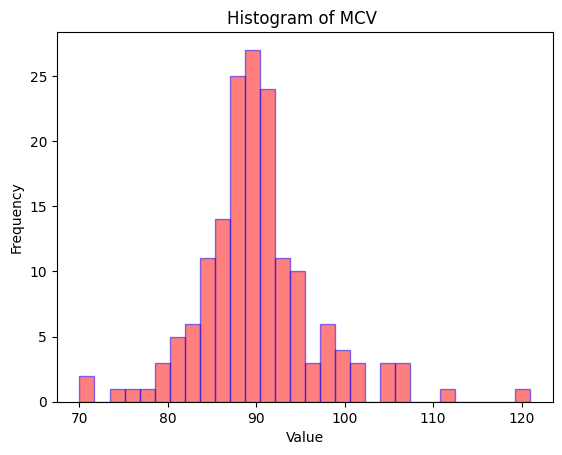

In [ ]:
plt.hist(final_df['MCV'], bins=30, alpha=0.5, color='r', edgecolor='blue')
plt.title("Histogram of MCV ")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

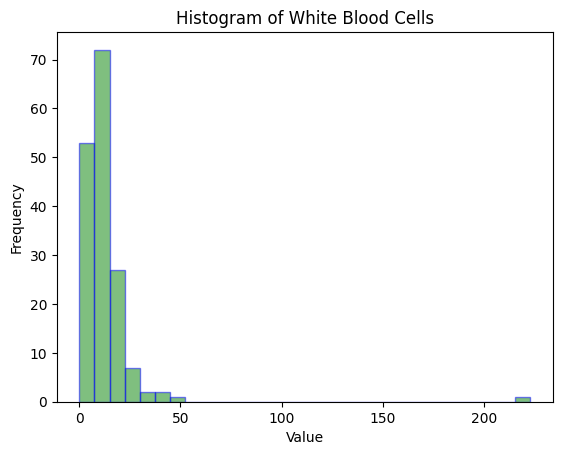

In [ ]:
plt.hist(final_df['White Blood Cells'], bins=30, alpha=0.5, color='g', edgecolor='blue')
plt.title("Histogram of White Blood Cells")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

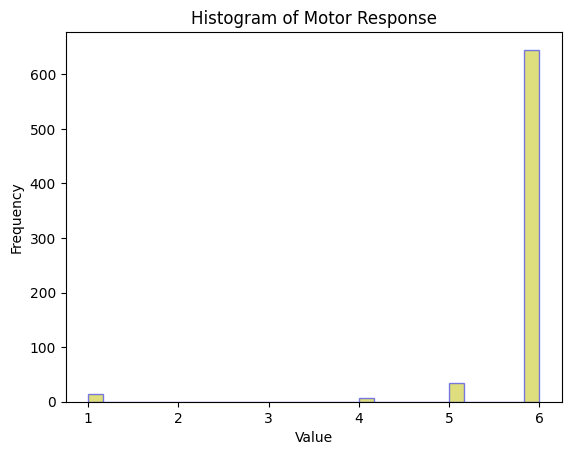

In [ ]:
plt.hist(final_df['Motor Response'], bins=30, alpha=0.5, color='y', edgecolor='blue')
plt.title("Histogram of Motor Response")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#Calculate the meann of data frames
mean = final_df.mean()
mean

Patient_ID                                                                                                                                                                    406.668675
BUN (6-20)                                                                                                                                                                     30.681818
Braden Score                                                                                                                                                                   14.745098
Carbon Dioxide                                                                                                                                                                 25.222222
Chloride (100-112)                                                                                                                                                            104.383117
                                                                           

In [ ]:
#Fill the empty values with mean
final_df.fillna(mean,inplace=True)

final_df.isna().sum().sum()

0

In [ ]:
final_df

,Patient_ID,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,Glucose (70-105),Heart Rate,...,Type_of_Heart_Failure_Acute systolic heart failure,Type_of_Heart_Failure_Chronic diastolic heart failure,Type_of_Heart_Failure_Chronic systolic heart failure,"Type_of_Heart_Failure_Combined systolic and diastolic heart failure, unspecified","Type_of_Heart_Failure_Congestive heart failure, unspecified","Type_of_Heart_Failure_Diastolic heart failure, unspecified","Type_of_Heart_Failure_Hypertensive heart and chronic kidney disease, unspecified, without heart failure and with chronic kidney disease stage V or end stage renal disease",Type_of_Heart_Failure_Left heart failure,Type_of_Heart_Failure_Rheumatic heart failure (congestive),"Type_of_Heart_Failure_Systolic heart failure, unspecified"
0,3,43.000000,13.000000,18.000000,106.000000,1.300000,4.000000,6.000000,140.00000,83.0,...,0,0,0,0,1,0,0,0,0,0
1,9,17.000000,15.000000,21.000000,100.000000,1.600000,1.000000,3.000000,143.00000,92.0,...,0,0,0,0,1,0,0,0,0,0
2,21,62.000000,13.000000,23.000000,102.000000,4.600000,3.000000,15.000000,102.00000,76.0,...,0,0,0,0,1,0,0,0,0,0
3,26,31.000000,16.000000,25.000000,106.000000,1.400000,4.000000,15.000000,106.00000,62.0,...,0,0,0,0,1,0,0,0,0,0
4,37,37.000000,16.000000,35.000000,103.000000,0.800000,4.000000,13.000000,74.00000,87.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,744,14.000000,16.000000,19.000000,109.000000,0.800000,4.000000,15.000000,134.00000,97.0,...,0,0,0,0,1,0,0,0,0,0
162,747,30.681818,14.745098,25.222222,104.383117,1.577273,3.571429,13.025974,134.36129,65.0,...,0,0,0,0,1,0,0,0,0,0
163,751,16.000000,17.000000,21.000000,101.000000,2.100000,4.000000,15.000000,191.00000,54.0,...,0,0,0,0,0,0,0,0,0,0
164,754,8.000000,14.000000,25.000000,108.000000,0.400000,4.000000,11.000000,119.00000,74.0,...,0,0,0,0,1,0,0,0,0,0


**Checking whether classes are imbalanced or not.**

In [ ]:
final_df['expire_flag'].value_counts()

expire_flag
1    104
0     62
Name: count, dtype: Int64

In [ ]:
survived = len(final_df[final_df['expire_flag']==0])
death = len(final_df[final_df['expire_flag']==1])
pct_of_survived= survived/(survived+death)
print("Percentage of survived patients is:", pct_of_survived*100)
pct_of_death = death/(survived+death)
print("Percentage of death patients is:", pct_of_death*100)

Percentage of survived patients is: 37.34939759036144
Percentage of death patients is: 62.65060240963856


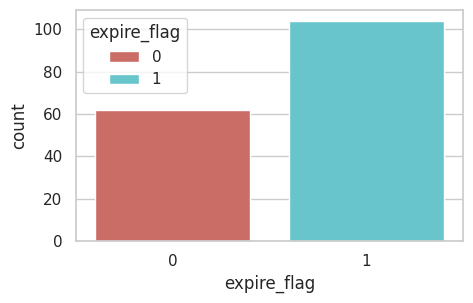

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize= (5,3))
sns.countplot(x='expire_flag',hue ='expire_flag',data=final_df,palette ='hls')
plt.show()
plt.savefig('count')

**Therefore, classes are slighty imblanced and can impact the accuracy of the model. Oversampling will be used to increase the number of survived patients**

# Model Training

**Input and target data**

In [ ]:
#Target variable
y = final_df['expire_flag']
X = final_df.drop(['expire_flag','Patient_ID'],axis=1)
X

,BUN (6-20),Braden Score,Carbon Dioxide,Chloride (100-112),Creatinine (0-1.3),Eye Opening,GCS Total,Glucose (70-105),Heart Rate,Hematocrit_x,...,Type_of_Heart_Failure_Acute systolic heart failure,Type_of_Heart_Failure_Chronic diastolic heart failure,Type_of_Heart_Failure_Chronic systolic heart failure,"Type_of_Heart_Failure_Combined systolic and diastolic heart failure, unspecified","Type_of_Heart_Failure_Congestive heart failure, unspecified","Type_of_Heart_Failure_Diastolic heart failure, unspecified","Type_of_Heart_Failure_Hypertensive heart and chronic kidney disease, unspecified, without heart failure and with chronic kidney disease stage V or end stage renal disease",Type_of_Heart_Failure_Left heart failure,Type_of_Heart_Failure_Rheumatic heart failure (congestive),"Type_of_Heart_Failure_Systolic heart failure, unspecified"
0,43.000000,13.000000,18.000000,106.000000,1.300000,4.000000,6.000000,140.00000,83.0,30.000000,...,0,0,0,0,1,0,0,0,0,0
1,17.000000,15.000000,21.000000,100.000000,1.600000,1.000000,3.000000,143.00000,92.0,33.500000,...,0,0,0,0,1,0,0,0,0,0
2,62.000000,13.000000,23.000000,102.000000,4.600000,3.000000,15.000000,102.00000,76.0,32.400002,...,0,0,0,0,1,0,0,0,0,0
3,31.000000,16.000000,25.000000,106.000000,1.400000,4.000000,15.000000,106.00000,62.0,36.799999,...,0,0,0,0,1,0,0,0,0,0
4,37.000000,16.000000,35.000000,103.000000,0.800000,4.000000,13.000000,74.00000,87.0,29.299999,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,14.000000,16.000000,19.000000,109.000000,0.800000,4.000000,15.000000,134.00000,97.0,29.000000,...,0,0,0,0,1,0,0,0,0,0
162,30.681818,14.745098,25.222222,104.383117,1.577273,3.571429,13.025974,134.36129,65.0,31.215790,...,0,0,0,0,1,0,0,0,0,0
163,16.000000,17.000000,21.000000,101.000000,2.100000,4.000000,15.000000,191.00000,54.0,32.400002,...,0,0,0,0,0,0,0,0,0,0
164,8.000000,14.000000,25.000000,108.000000,0.400000,4.000000,11.000000,119.00000,74.0,30.700001,...,0,0,0,0,1,0,0,0,0,0


# Train-test Split

In [ ]:
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5)

print("# of data samples for training:", len(X_train))
print("# of data samples for validation:", len(X_val))
print("# of data samples for testing:", len(X_test))

# of data samples for training: 132
# of data samples for validation: 17
# of data samples for testing: 17


In [ ]:
model = LogisticRegression(max_iter=100000)

In [ ]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=100000)

In [ ]:
w = model.coef_
b = model.intercept_

print("w = ", w)
print("b=", b)

w =  [[-2.28467878e-02 -2.45178136e-01  2.37578907e-01 -8.48415556e-02
   8.17314148e-02 -5.13192447e-01 -1.69671487e-01 -1.77274142e-02
   2.67545002e-02 -7.09654622e-02 -4.91031001e-01  1.66227109e-01
   1.15363453e-03 -6.91198606e-02  1.93795932e-01 -1.23436099e-02
  -1.66057028e-02 -7.63721442e-01 -4.07840792e-01  3.66939922e-01
  -1.45843720e-01 -2.91972828e-02 -9.06765406e-02  4.58132905e-01
  -2.93017354e-02 -1.95700248e-01  1.77676677e-02  1.02573187e-01
   2.67225509e-03 -6.14391855e-01 -6.69284603e-01  5.35246540e-01
   3.84490751e-01  5.85817237e-02  2.62106404e-01  2.06672109e-02
   9.50560638e-02 -3.53016679e-03  1.12874949e-01  1.12625126e-01
  -1.71672838e-01 -1.23198466e-01  4.67665420e-02 -7.22864160e-03
  -4.41786525e-01  4.86266686e-02  2.52394664e-02  7.36394688e-01
  -7.35825239e-01 -1.61512018e-01 -6.39217859e-02 -1.30431431e-01
   3.05725342e-02 -5.33656241e-01  4.64397922e-02  8.06902340e-02
   9.91927135e-01 -2.59538770e-01  8.06902340e-02 -2.82624109e-01
   0.

# **Making prediction**

# Logistic Regression

In [ ]:
y_pred = model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)*100))

Accuracy of logistic regression classifier on test set: 52.94


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[3, 3],
       [5, 6]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.38      0.50      0.43         6
         1.0       0.67      0.55      0.60        11

    accuracy                           0.53        17
   macro avg       0.52      0.52      0.51        17
weighted avg       0.56      0.53      0.54        17



# Desicion Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
des_tree = DecisionTreeClassifier()

In [ ]:
des_tree.fit(X_train,y_train)

DecisionTreeClassifier()

In [ ]:
dst_predict = des_tree.predict(X_test)
accuracy_dst= accuracy_score(y_test,dst_predict)*100
accuracy_dst

47.05882352941176

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, dst_predict)
confusion_matrix

array([[2, 4],
       [5, 6]])

# K-Nearest Neighours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)
knn5.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=30)

In [ ]:
knn_predict = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test,knn_predict)*100
accuracy_knn

41.17647058823529

In [ ]:
knn_predict5 = knn5.predict(X_test)
accuracy_knn5 = accuracy_score(y_test,knn_predict5)*100
accuracy_knn5

52.94117647058824